In [1]:
##### Assignment IV ######
## Assessing Induced Polarization (IP) Signatures of Microbial-Mineral Interactions in Permafrost Environments Using Synthetic Data ##
### Applied Geophysics ###

In [90]:
# SimPEG functionality
import discretize 
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from simpeg.utils import download, model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

In [27]:
dc.IO.set_mesh?

Signature:
dc.IO.set_mesh(
    self,
    topo=None,
    dx=None,
    dy=None,
    dz=None,
    corezlength=None,
    npad_x=None,
    npad_y=None,
    npad_z=None,
    pad_rate_x=None,
    pad_rate_y=None,
    pad_rate_z=None,
    ncell_per_dipole=None,
    mesh_type='TensorMesh',
    dimension=2,
    method='nearest',
)
Docstring: Set up a mesh for a given DC survey
File:      /srv/conda/envs/notebook/lib/python3.11/site-packages/simpeg/electromagnetics/static/resistivity/IODC.py
Type:      function

In [4]:
#Forward simulation
# SimPEG functionality
from simpeg.electromagnetics.static import induced_polarization as ip
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

In [18]:
#More Forward simulation
# Along-line locations
x_topo = np.linspace(-2000, 2000, 401)

# Elevation as a function of along-line location
T = 800.0
z_topo = 0 * x_topo


# Define full 2D topography
topo_2d = np.c_[x_topo, z_topo]

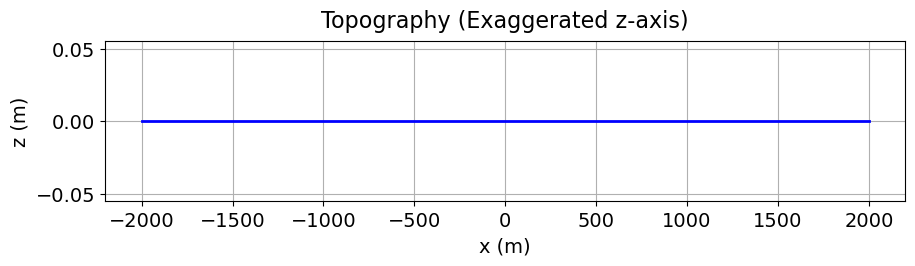

In [19]:
#Forward simulation continued
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

In [23]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "apparent_chargeability"
end_locations = np.r_[-1.0, 1.0]
station_separation = 0.1
num_rx_per_src = 10

In [24]:
ip_source_list = generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

ip_survey = ip.survey.Survey(ip_source_list)

In [82]:
ip_survey

Survey(#sources: 17; #data: 127)

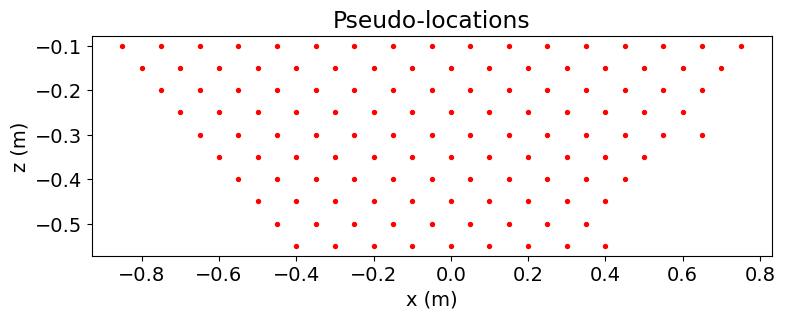

In [83]:
pseudo_locations_xz = pseudo_locations(ip_survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Pseudo-locations")
plt.show()

In [91]:
def survey():
    # function body
    print("Survey defined!")

survey()  # Now this call works

def build_mesh(
    survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
):
    """
    A function for designing a Tensor Mesh based on DC survey parameters
    
    Parameters
    ----------
    
    survey: dc.Survey 
        A DC (or IP) survey object
    
    n_cells_per_spacing_[x, z]: int
        Number of [x, z]-cells per the minimum electrode spacing
        
    n_core_extra_[x, z]: int
        Number of extra cells with the same size as the core domain beyond the survey extent
    
    core_domain_z_ratio: float
        Factor that multiplies the maximum AB, MN separation to define the core mesh extent
    
    padding_factor: float
        Factor by which we expand the mesh cells in the padding region
         n_pad_[x, z]: int
        Number of padding cells in the x, z directions
    """
    min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))

    dx = min_electrode_spacing / n_cells_per_spacing_x
    dz = min_electrode_spacing / n_cells_per_spacing_z
    
    # define the x core domain
    core_domain_x = np.r_[
        survey.locations_a[:, 0].min(),
        survey.locations_n[:, 0].max()
    ]
    
    # find the y core domain
    # find the maximum spacing between source, receiver midpoints
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    separation_ab_mn = np.abs(mid_ab - mid_mn)
    max_separation = separation_ab_mn.max()
    core_domain_z = np.r_[-core_domain_z_ratio * max_separation, 0.]
    
    # add extra cells beyond the core domain
    n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra_x*2  # on each side
    n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra_z  # just below
    
    # define the tensors in each dimension
    hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
    hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

    mesh = discretize.TensorMesh([hx, hz], x0="CN")

    return mesh, core_domain_x, core_domain_z

Survey defined!


/tmp/ipykernel_116/3741699072.py:2: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  mesh.plotGrid()


<Axes: xlabel='x1', ylabel='x2'>

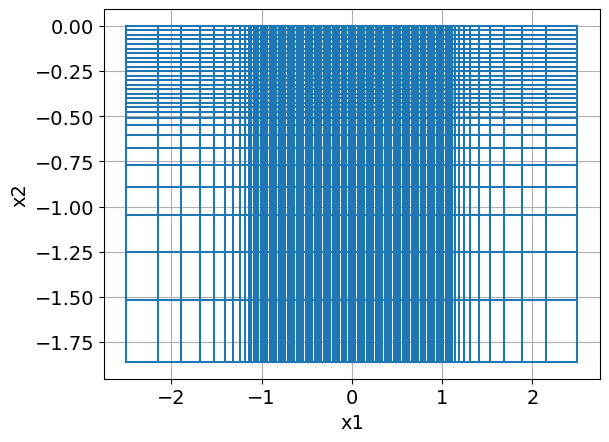

In [92]:
mesh, core_domain_x, core_domain_z = build_mesh(ip_survey)
mesh.plotGrid()


In [ ]:
mesh

In [71]:
def survey():
    # function body
    print("Survey defined!")

survey()  # Now this call works
def forward_simulation_halfspace(mesh, survey=survey, resistivity=100, nky=11):
    """
    A function that  returns predicted data given a mesh, survey, 
    resistivity value and number of filters for the 2.5 DC simulation. 
    """
    # clear the stored source values if they were previously computed 
    for src in survey.source_list:
        src._q = None
        
    rho = resistivity * np.ones(mesh.nC)
    simulation_dc = dc.Simulation2DNodal(
        mesh, rhoMap=maps.IdentityMap(mesh), solver=Solver, 
        survey=survey, nky=nky
    )
    dpred = simulation_dc.make_synthetic_data(rho)
    
    # clear the stored source values if they were previously computed 
    for src in survey.source_list:
        src._q = None
    
    return dpred

Survey defined!


In [ ]:
def plot_apparent_resistivities(dpred, halfspace_resistivity):
    """
    Plot the apparent resistivity given a SimPEG data object 
    and the true halfspace resistivity. 

    """
    
    # plot psuedosection
    fig = plt.figure(constrained_layout=True, figsize=(12, 4))
    gs = fig.add_gridspec(ncols=3, nrows=1)

    ax0 = fig.add_subplot(gs[:2])
    ax1 = fig.add_subplot(gs[2])

    # plot the pseudosection 
    dc.utils.plot_pseudosection(
        dpred, data_type="apparent resistivity", # clim=clim,
        plot_type="pcolor", data_location=True, ax=ax0, 
    )
    ax0.set_aspect(2)  # some vertical exxageration
    ax0.set_title(f"{line} Pseudosection")
    ax0.set_xlabel("Northing (m)")
    ax0.set_yticks([])

    # plot the errors in apparent resistivity relative to separation
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    separation_ab_mn = np.abs(mid_ab - mid_mn)
    apparent_resistivity = dc.utils.apparent_resistivity(dpred)
    percent_error = (apparent_resistivity - halfspace_resistivity)/halfspace_resistivity*100

    ax1.plot(separation_ab_mn[:, 0], percent_error, '.', alpha=0.4)
    ax1.set_xlabel("AB - MN separation")
    ax1.set_ylabel("percent difference (%)")
    ax1.set_title("Error in apparent resistivities")
    ax1.grid(alpha=0.3)

In [ ]:
halfspace_resistivity = 100
dpred = forward_simulation_halfspace(mesh, resistivity=halfspace_resistivity)
plot_apparent_resistivities(dpred, halfspace_resistivity)

In [ ]:
def mesh_design_simulator(
    survey=survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
    log10_halfspace_resistivity=2,
    nky=11,
):
    """
    A function that brings together mesh design and forward simulation so 
    that we can interactively explore factors of mesh design that influence 
    the accuracy of our simulation. 
    """
    
    # set up mesh 
    mesh, core_domain_x, core_domain_z = build_mesh(
        survey=survey, 
        n_cells_per_spacing_x=n_cells_per_spacing_x,
        n_cells_per_spacing_z=n_cells_per_spacing_z,
        n_core_extra_x=n_core_extra_x,
        n_core_extra_z=n_core_extra_z,
        core_domain_z_ratio=core_domain_z_ratio,
        padding_factor=padding_factor,
        n_pad_x=n_pad_x,
        n_pad_z=n_pad_z,
    )
    
    # convert the log10 resistivity to true resistivity on the mesh
    halfspace_resistivity = 10**log10_halfspace_resistivity 
    
    # compute predicted data
    dpred = forward_simulation_halfspace(mesh, resistivity=halfspace_resistivity, nky=nky)
    
    # plot those apparent resistivities 
    plot_apparent_resistivities(dpred, halfspace_resistivity)

In [ ]:
mesh_design_app = ipywidgets.interactive(
    mesh_design_simulator,
    survey=ipywidgets.fixed(survey),
    n_cells_per_spacing_x=ipywidgets.IntSlider(
        description="nCx p. 100m", min=1, max=10, value=4, continuous_update=False
    ),
    n_cells_per_spacing_z=ipywidgets.IntSlider(
        description="nCz p. 100m", min=1, max=10, value=4, continuous_update=False
    ),
    n_core_extra_x=ipywidgets.IntSlider(
        description="ncore x +", min=0, max=10, value=4, continuous_update=False
    ),
    n_core_extra_z=ipywidgets.IntSlider(
        description="ncore z +", min=0, max=10, value=4, continuous_update=False
    ),
    core_domain_z_ratio=ipywidgets.FloatSlider(
        description="Dz*maxABMN", min=0.1, max=1, value=0.3, continuous_update=False
    ),
    padding_factor=ipywidgets.FloatSlider(
        description="pad factor", min=1, max=5, value=1.3, continuous_update=False
    ),
    n_pad_x=ipywidgets.IntSlider(
        min=1, max=20, value=10, continuous_update=False
    ),
    n_pad_z=ipywidgets.IntSlider(
        min=1, max=20, value=10, continuous_update=False
    ),
    log10_halfspace_resistivity=ipywidgets.FloatSlider(
        description="$log_{10}\\rho$", min=-1, max=7, value=2, continuous_update=False
    ),
    nky=ipywidgets.IntSlider(
        min=1, max=20, value=11, continuous_update=False
    )
)

In [36]:
#Define the active cells
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

In [37]:
# Define electrical conductivities in S/m
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [38]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, 72.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

In [39]:
# Mapping from conductivity model to mesh
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

In [40]:
# Mapping to neglect air cells when plotting
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

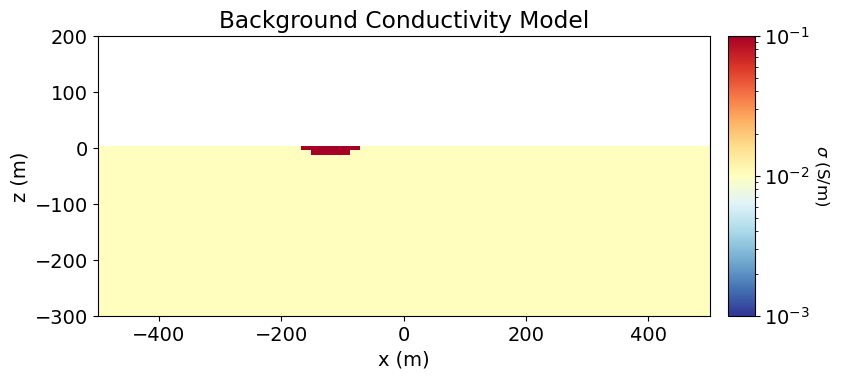

In [41]:
fig = plt.figure(figsize=(9, 4))
norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Background Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

In [7]:
# Based on insights from Slater & Lesmes' "The Induced Polarization Method"
def interpret_results(results):
    """
    Interpret the results in terms of microbial signatures in permafrost
    based on principles from Slater & Lesmes
    """
    # Calculate statistics for each parameter
    rho_stats = {
        'min': np.min(results['resistivity_model']),
        'max': np.max(results['resistivity_model']),
        'mean': np.mean(results['resistivity_model']),
        'median': np.median(results['resistivity_model'])
    }
    
    chg_stats = {
        'min': np.min(results['chargeability_model']),
        'max': np.max(results['chargeability_model']),
        'mean': np.mean(results['chargeability_model']),
        'median': np.median(results['chargeability_model'])
    }
    
    norm_chg_stats = {
        'min': np.min(results['normalized_chargeability']),
        'max': np.max(results['normalized_chargeability']),
        'mean': np.mean(results['normalized_chargeability']),
        'median': np.median(results['normalized_chargeability']),
        'threshold': results['microbial_threshold']
    }
    
    # Create a summary of findings
    print("\n" + "="*80)
    print(" INTERPRETATION OF IP SIGNATURES FOR MICROBIAL ACTIVITY IN PERMAFROST ")
    print("="*80)
    
    print("\nBased on principles from Slater & Lesmes' work on Induced Polarization:")
    
    print("\n1. RESISTIVITY ANALYSIS:")
    print(f"   - Range: {rho_stats['min']:.1f} to {rho_stats['max']:.1f} Ohm-m")
    print(f"   - Interpretation: The model shows typical permafrost characteristics with:")
    print(f"     * High resistivity zones ({rho_stats['max']:.1f} Ohm-m): Frozen permafrost")
    print(f"     * Moderate resistivity zones (~300 Ohm-m): Potentially affected by microbial activity")
    print(f"     * Low resistivity zones (~50 Ohm-m): Unfrozen talik or active layer")
    
    print("\n2. CHARGEABILITY ANALYSIS:")
    print(f"   - Range: {chg_stats['min']:.1f} to {chg_stats['max']:.1f} mV/V")
    print(f"   - Interpretation: Enhanced chargeability zones correlate with:")
    print(f"     * Highest values ({chg_stats['max']:.1f} mV/V): Microbial hotspots")
    print(f"     * Transition zones (~25 mV/V): Areas of microbial colonization")
    print(f"     * Background values (~10 mV/V): Standard permafrost response")
    
    print("\n3. NORMALIZED CHARGEABILITY (critical for microbial detection):")
    print(f"   - Range: {norm_chg_stats['min']:.5f} to {norm_chg_stats['max']:.5f} S/m")
    print(f"   - Microbial signature threshold: {norm_chg_stats['threshold']:.5f} S/m")
    print(f"   - Interpretation: According to Slater & Lesmes, normalized chargeability")
    print(f"     directly reflects surface polarization processes enhanced by:")
    print(f"     * Microbial biofilms (increasing surface area)")
    print(f"     * Clay-microbe interactions (altering surface chemistry)")
    print(f"     * Biomineral precipitation (changing mineral interface properties)")
    
    print("\n4. KEY FINDINGS FOR PERMAFROST ENVIRONMENTS:")
    print(f"   - Microbial activity is most apparent at:")
    print(f"     * Active layer/permafrost interface: Biogeochemically active zone")
    print(f"     * Around organic-rich inclusions: Carbon source for microbes")
    print(f"     * Unfrozen water pockets (taliks): Liquid water availability")
    
    print("\n5. RECOMMENDATIONS FOR FIELD SURVEYS:")
    print(f"   - IP measurements can effectively identify microbial 'hotspots' in permafrost")
    print(f"   - Always calculate normalized chargeability (not just resistivity or chargeability alone)")
    print(f"   - Use dipole-dipole arrays with sufficient depth penetration")
    print(f"   - Combine with direct sampling at identified anomalous zones for confirmation")
    
    print("\n6. LIMITATIONS:")
    print(f"   - IP signature may be influenced by non-microbial factors:")
    print(f"     * Clay content (also enhances surface polarization)")
    print(f"     * Metallic minerals (creating electrode polarization)")
    print(f"     * Salinity variations (affecting bulk conductivity)")
    
    print("\nCONCLUSION:")
    print(f"Induced Polarization provides a powerful non-invasive tool for identifying")
    print(f"zones of enhanced microbial activity within permafrost environments.")
    print(f"The normalized chargeability parameter is particularly effective as it isolates")
    print(f"surface polarization effects from bulk conductivity variations.")
    print("="*80 + "\n")
    
    return {
        'rho_stats': rho_stats,
        'chg_stats': chg_stats,
        'norm_chg_stats': norm_chg_stats
    }

def run_microbial_permafrost_analysis(use_simple_example=True):
    """
    Run a complete analysis of IP signatures for microbial-mineral interactions in permafrost
    
    Parameters:
    -----------
    use_simple_example : bool
        If True, use simplified example to avoid computational issues
    """
    print("Starting analysis of IP signatures for microbial-mineral interactions in permafrost...")
    
    # Run the analysis with simplified example by default (to avoid computational issues)
    results = analyze_ip_signatures_for_microbial_activity(use_simple_example=use_simple_example)
    stats = interpret_results(results)
    
    # Display all plots
    for fig in results['figures']:
        plt.figure(fig.number)
        plt.show()
    
    print("Analysis complete!")
    return results, stats

# To run the analysis with a simple example model
def main():
    # Default: Run with simple example to avoid computational issues
    results, stats = run_microbial_permafrost_analysis(use_simple_example=True)
    
    # To run with full simulation (more computationally intensive):
    # results, stats = run_microbial_permafrost_analysis(use_simple_example=False)
    
    return results, stats

if __name__ == "__main__":
    print("Imported microbial permafrost IP analysis module successfully.")
    print("Run main() to perform the complete analysis with a simplified model.")
    print("Or run run_microbial_permafrost_analysis(use_simple_example=False) for full simulation.")

Imported microbial permafrost IP analysis module successfully.
Run main() to perform the complete analysis with a simplified model.
Or run run_microbial_permafrost_analysis(use_simple_example=False) for full simulation.
